# DECISION FUSION IN TIME

IN: clinical data + RX t0
DECISION:   C1 = p1_1      C2 = p2_1
p1 or p2 are enough to decide? (choose parameter to be enough)

YES = DECISION TAKEN

NO = new image
IN 2: clinical data + RX t1
DECISION:   C1 = p1_2      C2 = p2_2

p1_2 or p2_2 compared to p1_1 and p2_1 are enough?

YES = DECISION TAKEN

NO = REPEAT UNTIL THERE ARE IMAGES


POSSIBILITY 2:

IN: clinical data   -> C1 = p1_c        C2 = p2_c


IN: RX_t0           -> C1 = p1_rx_t0    C2 = p2_rx_t0


DECISION = Combine [p1_c,p2_c,p1_rx_t0,p2_rx_t0]  and obtain pC1,pC2

if pC1,pC2 is not enough to make a decision: 

IN: RX_t1           -> C1 = p1_rx_t1    C2 = p2_rx_t1


DECISION = Combine [p1_c,p2_c,p1_rx_t1,p2_rx_t1]  and obtain pC1,pC2            or Combine as [p1_c,p2_c,p1_rx_t0,p2_rx_t0,p1_rx_t1,p2_rx_t1]   with all precedent times

if pC1,pC2 is not enough to make a decision: REPEAT UNTIL there are images

## IMPORT ALL

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import gc
import copy
import cv2

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm

import sklearn as sk
import tensorflow as tf
# import tensorflow.keras as keras
from tensorflow import keras
from pathlib import Path
import plotly.graph_objects as go
import keras.backend as K

import imblearn
from imblearn.over_sampling import RandomOverSampler

In [2]:
print(f"Python Version: {sys.version}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Imbalanced Learn Version: {imblearn.__version__}")

Python Version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Pandas Version: 1.4.3
Numpy Version: 1.23.1
Keras Version: 2.9.0
Imbalanced Learn Version: 0.9.1


In [3]:
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

In [4]:
import tensorflow_addons as tfa

c:\Users\Michele\anaconda3\envs\2022tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## FUNCTIONS

In [5]:
sys.path.append('./')
import Covid19_NY_Data_Loader_functions as load_fn
import Covid19_NY_Clinical_Data_Functions as clinical_fn
import Covid19_NY_CNN_Functions as cnn_fn

### DATA LOADER FUNCTIONS

### CLINICAL DATA FUNCTIONS

### CNN FUNCTIONS

## Paths

In [6]:
BASEPT = Path('../Temporal-Decision-Fusion/')
BASEPT.mkdir(parents=True, exist_ok=True)
SaveTrainGraphPath = Path('../Temporal-Decision-Fusion/Report/Graphs')
SaveTrainGraphPath.mkdir(parents=True, exist_ok=True)
SaveTrainModelsPath = Path('../Temporal-Decision-Fusion/Report/Models')
SaveTrainModelsPath.mkdir(parents=True, exist_ok=True)
SaveTrainTablesPath = Path('../Temporal-Decision-Fusion/Report/tables')
SaveTrainTablesPath.mkdir(parents=True, exist_ok=True)
SaveTrainPredictionsPath = Path('../Temporal-Decision-Fusion/Report/predictions')
SaveTrainPredictionsPath.mkdir(parents=True, exist_ok=True)

imagesBasePath = Path('../COVID-19-CHEST-ONLY/manifest-1645033969298/')
tablePath = Path('DB_in_time.csv')


## STATIC VARIABLES

In [7]:
SEED = 42
IMG_SIZE = 224  #single number WxH

## LOAD INPUTS

In [8]:
# load DB
COVID19 = pd.read_csv(tablePath)

In [9]:
COVID19.head()

,Unnamed: 0.1,number_images_in_time,images_paths_in_time,images_timestamp,index,Unnamed: 0,to_patient_id,covid19_statuses,last.status,age.splits,...,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy,FilePaths
0,0,34.0,[WindowsPath('COVID-19-NY-SBU/A000801/12-25-19...,"[Timestamp('1900-12-25 00:00:00'), Timestamp('...",320.0,351.0,A000801,positive,discharged,"[18,59]",...,32.0,130.0,38.0,21.0,107.0,16.0,True,True,not documented,/SEVERE/320_A000801.png
1,1,2.0,[WindowsPath('COVID-19-NY-SBU/A000936/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",705.0,765.0,A000936,positive,discharged,"(59,74]",...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented,/MILD/705_A000936.png
2,2,3.0,[WindowsPath('COVID-19-NY-SBU/A001942/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",890.0,965.0,A001942,positive,discharged,"[18,59]",...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented,/MILD/890_A001942.png
3,3,2.0,[WindowsPath('COVID-19-NY-SBU/A001375/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",1098.0,1183.0,A001375,positive,discharged,"[18,59]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/MILD/1098_A001375.png
4,4,90.0,[WindowsPath('COVID-19-NY-SBU/A002052/12-27-19...,"[Timestamp('1900-12-27 00:00:00'), Timestamp('...",63.0,70.0,A002052,positive,discharged,"[18,59]",...,57.0,308.0,NaN,NaN,NaN,NaN,True,False,not documented,/SEVERE/63_A002052.png


In [10]:
COVID19 = COVID19.drop(["Unnamed: 0.1", "Unnamed: 0", 'index', 'FilePaths'], axis='columns')

### Taking care of nan

In [11]:
print("cell that are NaN: "+str(COVID19.isna().sum().sum()))
print("num cells in DB: " + str(COVID19.size))
print('percentage of NaN: '+str((COVID19.isna().sum().sum()/COVID19.size)*100))

cell that are NaN: 44341
num cells in DB: 171386
percentage of NaN: 25.872008215373484


In [12]:
# ONE HOT ENCODER?

#For HFrEF, documented ICD-10 code for HFrEF or echocardiogram documenting reduced ejection fraction (reduced EF is <40%, 40% or higher is preserved EF). For HFpEF, documented ICD-10 code for HFpEF or echocardiogram documenting diastolic dysfunction.
hf_ef_v = {'HFpEF': 1, 'HFrEF': 2, 'No': 0}
COVID19 = COVID19.replace({'hf_ef_v': hf_ef_v})

In [13]:
COVID19 = COVID19.replace({'Yes':True,'No':False})

In [14]:
#GENDER: female = True, male = False
gender = {'FEMALE': True, 'MALE': False}
COVID19 = COVID19.replace({'gender_concept_name': gender})

In [15]:
#last status: discharged = True, deceased = False
last_s = {'discharged': True, 'deceased': False}
COVID19 = COVID19.replace({'last.status': last_s})

In [16]:
#AGE: [18,59] = 0, (59,74] = 1, (74,90] = 2
age = {'[18,59]': (59+18)/2, '(59,74]': (74+60)/2, '(74,90]': (90+75)/2}
COVID19 = COVID19.replace({'age.splits': age})

In [17]:
#INVASIVE VENT DAYS     IF VENTILATED = TRUE: SET NUMBER IF NOT THEN = 0
COVID19.loc[COVID19['was_ventilated'] == False, 'invasive_vent_days'] = 0
# print(db_COVID19['invasive_vent_days'].isnull().sum())  #save this col

In [18]:
# ONE HOT ENCODER?

# #SMOKING STATUS :  Never = 0, Former = 1, Current = 2
# smoking_status = {'Current': 2, 'Former': 1, 'Never': 0}
# COVID19 = COVID19.replace({'smoking_status_v': smoking_status})

#one hot encoder Hospitals
SMOKING= ['Current','Former','Never','Unknown']

mapping = {}
for x in range(len(SMOKING)):
    mapping[SMOKING[x]] = x

takename = copy.deepcopy(COVID19['smoking_status_v'])

takename = takename.fillna('Unknown')
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['Current Smoker'] = one_h_enc[:,0]
COVID19['Former Smoker'] = one_h_enc[:,1]
COVID19['Never Smoker'] = one_h_enc[:,2]
COVID19['Unknown Smoker'] = one_h_enc[:,3]

COVID19 = COVID19.drop(['smoking_status_v'], axis='columns')

In [19]:
#URINE PROTEIN: Normal = True, Abnormal = False
urine = {'Normal': False, 'Abnormal': True}
COVID19 = COVID19.replace({'Urine.protein': urine})

In [20]:
ANTICOUAGULATION= ['apixaban','argatroban','dabigatran','multiple','not documented','rivaroxaban','wafarin','NO']

mapping = {}
for x in range(len(ANTICOUAGULATION)):
    mapping[ANTICOUAGULATION[x]] = x

takename = copy.deepcopy(COVID19['Other.anticoagulation.therapy'])
takename = takename.fillna('NO')
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['anticoagulation_therapy_apixaban'] = one_h_enc[:,0]
COVID19['anticoagulation_therapy_argatroban'] = one_h_enc[:,1]
COVID19['anticoagulation_therapy_dabigatran'] = one_h_enc[:,2]
COVID19['anticoagulation_therapy_multiple'] = one_h_enc[:,3]
COVID19['anticoagulation_therapy_not_documented'] = one_h_enc[:,4]
COVID19['anticoagulation_therapy_rivaroxaban'] = one_h_enc[:,5]
COVID19['anticoagulation_therapy_wafarin'] = one_h_enc[:,6]
COVID19['NO_anticoagulation_therapy'] = one_h_enc[:,7]

COVID19 = COVID19.drop(['Other.anticoagulation.therapy'], axis='columns')

In [21]:
# ONE HOT ENCODER?

#SMOKING STATUS :  Never = 0, Former = 1, Current = 2
is_ICU = {False: 'MILD', True: 'SEVERE'}
COVID19 = COVID19.replace({'is_icu': is_ICU})

#one hot encoder Hospitals
ICU= ['MILD','SEVERE']

mapping = {}
for x in range(len(ICU)):
    mapping[ICU[x]] = x

takename = copy.deepcopy(COVID19['is_icu'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['MILD'] = one_h_enc[:,0]
COVID19['SEVERE'] = one_h_enc[:,1]

COVID19 = COVID19.drop(['is_icu'], axis='columns')

In [22]:
COVID19.head()

,number_images_in_time,images_paths_in_time,images_timestamp,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,...,anticoagulation_therapy_apixaban,anticoagulation_therapy_argatroban,anticoagulation_therapy_dabigatran,anticoagulation_therapy_multiple,anticoagulation_therapy_not_documented,anticoagulation_therapy_rivaroxaban,anticoagulation_therapy_wafarin,NO_anticoagulation_therapy,MILD,SEVERE
0,34.0,[WindowsPath('COVID-19-NY-SBU/A000801/12-25-19...,"[Timestamp('1900-12-25 00:00:00'), Timestamp('...",A000801,positive,True,38.5,False,12/29/1900,Inpatient Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2.0,[WindowsPath('COVID-19-NY-SBU/A000936/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A000936,positive,True,67.0,True,1/11/1901,Emergency Room Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3.0,[WindowsPath('COVID-19-NY-SBU/A001942/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001942,positive,True,38.5,False,1/5/1901,Emergency Room Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2.0,[WindowsPath('COVID-19-NY-SBU/A001375/12-31-19...,"[Timestamp('1900-12-31 00:00:00'), Timestamp('...",A001375,positive,True,38.5,True,1/12/1901,Emergency Room Visit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,90.0,[WindowsPath('COVID-19-NY-SBU/A002052/12-27-19...,"[Timestamp('1900-12-27 00:00:00'), Timestamp('...",A002052,positive,True,38.5,False,12/28/1900,Inpatient Visit,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [23]:
# drop col active:

COVID19 = COVID19.drop(["last.status"], axis="columns")

In [129]:
print("cell that are NaN: "+str(COVID19.isna().sum().sum()))
print("num cells in DB: " + str(COVID19.size))
print('percentage of NaN: '+str((COVID19.isna().sum().sum()/COVID19.size)*100))

cell that are NaN: 0
num cells in DB: 184176
percentage of NaN: 0.0


In [130]:
COVID19 = load_fn.fillWithMean(COVID19)
COVID19 = COVID19.fillna(-1)

numeric cols with nan values: ['number_images_in_time', 'age.splits', 'invasive_vent_days', 'length_of_stay', 'hf_ef_v', 'days_prior_sx', '8331-1_Oral temperature', '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry', '9279-1_Respiratory rate', '76282-3_Heart rate.beat-to-beat by EKG', '8480-6_Systolic blood pressure', '76536-2_Mean blood pressure by Noninvasive', '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count', '751-8_Neutrophils [#/volume] in Blood by Automated count', '731-0_Lymphocytes [#/volume] in Blood by Automated count', '2951-2_Sodium [Moles/volume] in Serum or Plasma', '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma', "1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P", '2157-6_Creatine kinase [Enzymatic activity/volume] in Serum or Plasma', '2524-7_Lactate [Moles/volume] in Serum or Plasma', '6598-7_Troponin T.cardiac [Mass/vol

In [131]:
print("cell that are NaN: "+str(COVID19.isna().sum().sum()))
print("num cells in DB: " + str(COVID19.size))
print('percentage of NaN: '+str((COVID19.isna().sum().sum()/COVID19.size)*100))

cell that are NaN: 0
num cells in DB: 184176
percentage of NaN: 0.0


### Division Clinical and Images

In [132]:
imgCols = ["number_images_in_time","images_paths_in_time","images_timestamp","to_patient_id"]
y_cols = ["MILD","SEVERE"]
drop_cols = ["number_images_in_time","images_paths_in_time","images_timestamp","visit_start_datetime","was_ventilated","invasive_vent_days","length_of_stay","MILD","SEVERE"]

In [133]:
clinicalDB = COVID19.drop(drop_cols,axis="columns")
imgDB = COVID19[imgCols]
Y_FULL = COVID19[y_cols]

### Crop casually some of the majority classes

In [134]:
mildNumber = Y_FULL.sum()[0]
print(mildNumber)
severeNumber = Y_FULL.sum()[1]
print(severeNumber)
total = Y_FULL.sum().sum()

1022.0
257.0


In [135]:
Y_FULL.head()

,MILD,SEVERE
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [136]:
np.random.seed(SEED)

remove_n = int((mildNumber - severeNumber)*0.5)
print(remove_n)
drop_indices = Y_FULL.query("MILD > 0").sample(n=remove_n).index.to_list()
print(drop_indices)
Y_FULL_REMOVED = Y_FULL.drop(drop_indices)
clinicalDB_REMOVED = clinicalDB.drop(drop_indices)
imgDB_REMOVED = imgDB.drop(drop_indices)

382
[1240, 587, 853, 36, 764, 851, 684, 1034, 84, 1247, 724, 77, 980, 114, 769, 810, 780, 362, 858, 550, 109, 1128, 314, 426, 657, 860, 444, 1057, 1105, 604, 892, 859, 1261, 644, 1132, 920, 254, 731, 448, 238, 936, 779, 1028, 428, 397, 588, 1116, 294, 345, 348, 624, 1060, 66, 876, 382, 13, 286, 400, 874, 97, 1150, 209, 375, 571, 260, 35, 536, 540, 59, 27, 309, 670, 5, 493, 1045, 827, 488, 1212, 975, 611, 591, 1191, 1225, 712, 1027, 256, 1063, 1253, 652, 831, 44, 278, 825, 873, 707, 73, 356, 74, 590, 396, 1044, 121, 608, 421, 361, 677, 370, 905, 1176, 359, 838, 830, 113, 99, 70, 1046, 1112, 164, 940, 763, 617, 829, 726, 123, 1148, 871, 662, 884, 775, 160, 882, 1099, 935, 189, 373, 394, 577, 817, 306, 332, 947, 222, 710, 969, 1185, 249, 202, 1074, 339, 1274, 671, 60, 139, 1121, 29, 80, 668, 49, 614, 237, 466, 378, 683, 248, 881, 823, 664, 903, 750, 732, 349, 1197, 401, 250, 412, 67, 416, 743, 757, 1254, 525, 312, 803, 747, 981, 759, 596, 648, 1009, 1061, 1206, 124, 607, 637, 1049, 1164, 

In [137]:
mildNumber = Y_FULL_REMOVED.sum()[0]
print(mildNumber)
severeNumber = Y_FULL_REMOVED.sum()[1]
print(severeNumber)
total = Y_FULL_REMOVED.sum().sum()

640.0
257.0


In [138]:
# train // val
# X_cl_train, X_cl_val, Y_cl_train, Y_cl_val = train_test_split(clinicalDB,Y_FULL_REMOVED, test_size=0.2,shuffle=True, random_state=SEED)
# X_pt_train, X_pt_val, Y_im_train, Y_im_val = train_test_split(imgDB,Y_FULL_REMOVED, test_size=0.2,shuffle=True, random_state=SEED)

X_cl_train, X_cl_val, Y_cl_train, Y_cl_val = train_test_split(clinicalDB_REMOVED,Y_FULL_REMOVED, test_size=0.2,shuffle=True, random_state=SEED)
X_pt_train, X_pt_val, Y_im_train, Y_im_val = train_test_split(imgDB_REMOVED,Y_FULL_REMOVED, test_size=0.2,shuffle=True, random_state=SEED)

#### Oversampling littlest class

In [139]:
oversampling = True

if oversampling:
    Y_im_train = np.argmax(Y_im_train.to_numpy(), axis=1)

    oversample = RandomOverSampler(sampling_strategy='minority')

    X_pt_train, Y_im_train = oversample.fit_resample(X_pt_train, Y_im_train)

    Y_im_train = np.tile(Y_im_train, (2, 1))
    Y_im_train[1,:] = Y_im_train[1,:] -1
    Y_im_train[1,:] = Y_im_train[1,:] * (-1)
    Y_im_train = np.transpose(Y_im_train)

    print(Y_im_train.shape)

(1014, 2)


#### IMAGE LOADING

In [140]:
# t0 images loading
t0_IMG_train = load_fn.loadImgTimeToArray(X_pt_train,IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
# t0_IMG_train = load_fn.loadImgTimeToArray(X_pt_train[:10],IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
t0_IMG_val = load_fn.loadImgTimeToArray(X_pt_val,IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
# t0_IMG_val = load_fn.loadImgTimeToArray(X_pt_val[:5],IMG_SIZE,"images_paths_in_time",0,imagesBasePath)
# NEED OF OCR?

100%|██████████| 180/180 [00:04<00:00, 39.35it/s]


In [141]:
# # load all images of NY DB
# X_IMG_train = load_fn.loadAllImgTimeToArray(X_pt_train,IMG_SIZE,"images_paths_in_time",imagesBasePath)
# X_IMG_val = load_fn.loadAllImgTimeToArray(X_pt_val,IMG_SIZE,"images_paths_in_time",imagesBasePath)

In [142]:
# X_IMG_train.shape

In [143]:
# # new Y_train and Y_val for all images:
# Y_train = []
# for r_im,y_im in zip(X_pt_train,Y_im_train):
#     nIm = r_im['number_images_in_time']
#     yOutMILD = y_im['MILD']
#     yOutSEVERE = y_im['SEVERE']
#     nOut = np.array([yOutMILD,yOutSEVERE])
#     for i in range(nIm):
#         Y_train.append(nOut)
    
# Y_train = np.array(Y_train)

# Y_val = []
# for r_im,y_im in zip(X_pt_val,Y_im_val):
#     nIm = r_im['number_images_in_time']
#     yOutMILD = y_im['MILD']
#     yOutSEVERE = y_im['SEVERE']
#     nOut = np.array([yOutMILD,yOutSEVERE])
#     for i in range(nIm):
#         Y_val.append(nOut)
    
# Y_val = np.array(Y_val)

In [144]:
# print(t0_IMG_val[4])

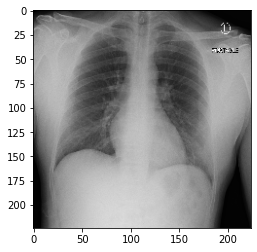

In [145]:
plt.figure()
plt.imshow(t0_IMG_train[4])

#### CLINICAL NORMALIZATION

In [146]:
X_cl_train = X_cl_train.drop(['to_patient_id','visit_concept_name', 'covid19_statuses'], axis='columns')
X_cl_val = X_cl_val.drop(['to_patient_id','visit_concept_name', 'covid19_statuses'], axis='columns')

scaler = MinMaxScaler()
X_cl_train = pd.DataFrame(scaler.fit_transform(X_cl_train), columns=X_cl_train.columns,index=X_cl_train.index)
X_cl_val = pd.DataFrame(scaler.transform(X_cl_val), columns=X_cl_val.columns,index=X_cl_val.index)


## FINE TUNING FROM HACKATHON TO NY CNN

Fine tuning of all images and save table with probabilistic output

In [150]:
pathCNNHack = Path('../../FUSION 2022/DATABASE_CNN/MultilayerFusion/callbacks/ASI_DS_best_accuracy_CNN_model')
pathCNNHack = Path('../../FUSION 2022/DATABASE_CNN/MultilayerFusion/Output-Decent-73ca/callbacks/ASI_DS_best_accuracy_CNN_model')




In [151]:
CNN = tf.keras.models.load_model(pathCNNHack)
# CNN.trainable = False

# for layer in CNN.layers[-15:]:
#     layer.trainable = True

In [152]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

CNN.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
        # optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-10),
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),   #!!!!!!!!
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2),
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01, decay= 0.00001),
        # loss="binary_crossentropy",
        # loss="categorical_crossentropy",
        loss="hinge",
        # loss=hingeLossSk,
        # metrics=['accuracy', precision, recall],
        metrics=['accuracy'],
        # run_eagerly=True,
)

# CREATE CALLBACKS
checkpoint_accuracy = tf.keras.callbacks.ModelCheckpoint(
						SaveTrainModelsPath / Path('CNN_Fine_tuned_from_hackathon'), 
						monitor='val_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint_binary_acc = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/ASI_DS_best_binary_accuracy_CNN_model', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=0)

callbacks_list = [checkpoint_accuracy, early_stopping]

history = CNN.fit(
        x = t0_IMG_train,
        y = Y_im_train,
        epochs = 1000,
        validation_data = [t0_IMG_val,Y_im_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=16
)

Epoch 1/1000
64/64 [==============================] - ETA: 0s - loss: 1.0152 - accuracy: 0.4911
Epoch 1: val_accuracy improved from -inf to 0.26111, saving model to ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon\assets


64/64 [==============================] - 10s 129ms/step - loss: 1.0152 - accuracy: 0.4911 - val_loss: 1.3487 - val_accuracy: 0.2611
Epoch 2/1000
64/64 [==============================] - ETA: 0s - loss: 0.9511 - accuracy: 0.5927
Epoch 2: val_accuracy did not improve from 0.26111
64/64 [==============================] - 1s 15ms/step - loss: 0.9511 - accuracy: 0.5927 - val_loss: 1.6151 - val_accuracy: 0.2611
Epoch 3/1000
61/64 [===========================>..] - ETA: 0s - loss: 0.9444 - accuracy: 0.5943
Epoch 3: val_accuracy improved from 0.26111 to 0.73889, saving model to ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon\assets


64/64 [==============================] - 7s 114ms/step - loss: 0.9428 - accuracy: 0.5976 - val_loss: 0.7306 - val_accuracy: 0.7389
Epoch 4/1000
62/64 [============================>.] - ETA: 0s - loss: 0.9413 - accuracy: 0.5776
Epoch 4: val_accuracy did not improve from 0.73889
64/64 [==============================] - 1s 16ms/step - loss: 0.9410 - accuracy: 0.5779 - val_loss: 0.6754 - val_accuracy: 0.7389
Epoch 5/1000
61/64 [===========================>..] - ETA: 0s - loss: 0.9388 - accuracy: 0.5891
Epoch 5: val_accuracy did not improve from 0.73889
64/64 [==============================] - 1s 15ms/step - loss: 0.9351 - accuracy: 0.5927 - val_loss: 0.6891 - val_accuracy: 0.7389
Epoch 6/1000
61/64 [===========================>..] - ETA: 0s - loss: 0.9219 - accuracy: 0.6230
Epoch 6: val_accuracy did not improve from 0.73889
64/64 [==============================] - 1s 15ms/step - loss: 0.9259 - accuracy: 0.6174 - val_loss: 0.6971 - val_accuracy: 0.7389
Epoch 7/1000
64/64 [==================

INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon\assets


INFO:tensorflow:Assets written to: ..\Temporal-Decision-Fusion\Report\Models\CNN_Fine_tuned_from_hackathon\assets


64/64 [==============================] - 7s 114ms/step - loss: 0.7526 - accuracy: 0.7288 - val_loss: 0.9937 - val_accuracy: 0.7444
Epoch 156/1000
64/64 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.7229
Epoch 156: val_accuracy did not improve from 0.74444
64/64 [==============================] - 1s 18ms/step - loss: 0.7623 - accuracy: 0.7229 - val_loss: 1.1284 - val_accuracy: 0.7000
Epoch 157/1000
61/64 [===========================>..] - ETA: 0s - loss: 0.7649 - accuracy: 0.7049
Epoch 157: val_accuracy did not improve from 0.74444
64/64 [==============================] - 1s 16ms/step - loss: 0.7656 - accuracy: 0.7041 - val_loss: 1.0879 - val_accuracy: 0.5722
Epoch 158/1000
61/64 [===========================>..] - ETA: 0s - loss: 0.7636 - accuracy: 0.7100
Epoch 158: val_accuracy did not improve from 0.74444
64/64 [==============================] - 1s 16ms/step - loss: 0.7626 - accuracy: 0.7120 - val_loss: 1.0350 - val_accuracy: 0.7389
Epoch 159/1000
61/64 [====

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                  width=700,
                  title='Loss CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation accuracy'))
# fig.add_trace(go.Scatter(
#                     y=history.history['precision'],
#                     name='Train precision'))
# fig.add_trace(go.Scatter(
#                     y=history.history['val_precision'],
#                     name='Validation precision'))
# fig.add_trace(go.Scatter(
#                     y=history.history['recall'],
#                     name='Train recall'))
# fig.add_trace(go.Scatter(
#                     y=history.history['val_recall'],
#                     name='Validation recall'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy/Precision/Recall CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix, hinge_loss

In [ ]:
bestPt = SaveTrainModelsPath / Path('CNN_Fine_tuned_from_hackathon')
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = t0_IMG_val, y = Y_im_val)
prediction = model.predict(t0_IMG_val)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_im_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

Hloss = hinge_loss(yground, ypreds)
print('hinge_loss: ', Hloss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)





evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(SaveTrainPredictionsPath / Path('ASI_DS_NY_best_accuracy_tuned_CNN.txt', 'w')) as f:
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN FUSION BY DS TR: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Hinge Loss') + ' >>> '+ str(Hloss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

# TIME MODAL TRAINING